# start

In [1]:
PRFX='Dev0727_5'

- https://www.kaggle.com/drhabib/starter-kernel-for-0-79/

In [2]:
!pip install ../input/efficientnetpytorch/efficientnet_pytorch-0.3.0-py3-none-any.whl

In [3]:
!nvidia-smi

Sun Jul 28 03:07:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   57C    P0    44W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b3-c8376fa2.pth
import os
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')

!cp ../input/efficientnetpytorch/*.pth /tmp/.cache/torch/checkpoints/

# params

In [5]:
p_o = f'../output/{PRFX}'
from pathlib import Path
Path(p_o).mkdir(exist_ok=True, parents=True)

SEED = 111

BS = 64
FP16 = True
PERC_VAL = 0.1
WD = 0.01


MODEL_NAME = 'efficientnet-b5'
from efficientnet_pytorch import EfficientNet
SZ = EfficientNet.get_image_size(MODEL_NAME)
for i in range(6):
    print(f'efficientnet-b{i} size', EfficientNet.get_image_size(f'efficientnet-b{i}'))

SZ = 224
print('SZ:', SZ)



from fastai.vision import *
params_tfms = {}


efficientnet-b0 size 224
efficientnet-b1 size 240
efficientnet-b2 size 260
efficientnet-b3 size 300
efficientnet-b4 size 380
efficientnet-b5 size 456
SZ: 224


## img proc

In [6]:
use_open_yz = True

import cv2
def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image, _ = crop_margin(image)
    image = center_crop(image)
    image = cv2.resize(image, (640, 480))#most common in test
#     image = cv2.resize(image, (SZ, SZ))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

> get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

In [7]:
from fastai.vision import *
params_tfms = dict(
    do_flip=True,
    flip_vert=True,
)

> By default, the library resizes the image while keeping its original ratio so that the smaller size corresponds to the given size, then takes a crop (ResizeMethod.CROP). You can choose to resize the image while keeping its original ratio so that the bigger size corresponds to the given size, then take a pad (ResizeMethod.PAD). Another way is to just squish the image to the given size (ResizeMethod.SQUISH).

In [8]:
kwargs_tfms = dict(
    resize_method=ResizeMethod.SQUISH,
    padding_mode='zeros'
)

# setup

In [9]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

## image processing

In [10]:
import cv2

def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

    
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))
    
if use_open_yz:
    vision.data.open_image = open_yz

## QWK

In [11]:
import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

def qwk(y_pred, y):
    return torch.tensor(
        quadratic_weighted_kappa(torch.round(y_pred), y),
        device='cuda:0')

## set seed

In [12]:
def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False

set_torch_seed()

## TTTA

In [13]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms if o.tfm !=zoom]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

## optimizer

In [14]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']


# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

    
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

# preprocess

## prep

In [15]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [16]:
img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
t2c_trn_has = dict(cnt)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [17]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
train=pd.read_csv(pp/'trainLabels.csv')
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'retinopathy_solution.csv')
img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1],'diab')  for o in test.values]
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())


38788

[(0, 27615), (2, 6291), (1, 2813), (3, 1066), (4, 1003)]

92364

[(0, 67148), (2, 14152), (1, 6575), (3, 2280), (4, 2209)]

In [18]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1],'idrid')  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1],'idrid')  for o in test.values]
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

92777

[(0, 67282), (2, 14288), (1, 6595), (3, 2354), (4, 2258)]

92880

[(0, 67316), (2, 14320), (1, 6600), (3, 2373), (4, 2271)]

In [19]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target', 'src']
df = df.reset_index()
df.shape

(92880, 4)

In [20]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

## df2use

In [21]:
df2use = df[df.src.isin(['blnd', 'idrid'])].copy()

df2use.target.value_counts()

0    1973
2    1167
1     395
4     357
3     286
Name: target, dtype: int64

In [22]:
n_t_wanted = 2000
n_t_extra = dict(n_t_wanted - df2use.target.value_counts())
n_t_extra

{0: 27, 2: 833, 1: 1605, 4: 1643, 3: 1714}

In [23]:
set_torch_seed()
for t,n in n_t_extra.items():
    df2use = pd.concat([df2use, df[(df.target==t) & (df.src=='diab')].sample(n)])

In [24]:
df2use.shape

(10000, 4)

In [25]:
df2use.target.value_counts()

4    2000
3    2000
2    2000
1    2000
0    2000
Name: target, dtype: int64

## dataset

In [26]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz=SZ, bs=BS):
    src = (ImageList.from_df(df=df2use,path='./',cols='fnm') 
            .split_by_rand_pct(0.2) 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz,
                         **kwargs_tfms
                         ) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data


set_torch_seed()
data = get_data()

CPU times: user 1min 9s, sys: 2.94 s, total: 1min 12s
Wall time: 1min 2s


CPU times: user 4.41 s, sys: 1.47 s, total: 5.87 s
Wall time: 1min 40s


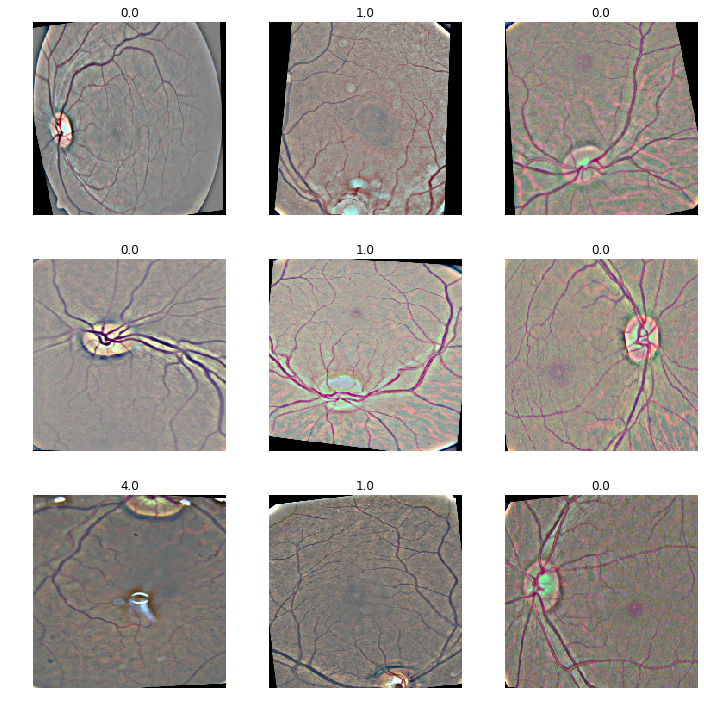

In [27]:
%%time
data.show_batch(rows=3, figsize=(10, 10))

## add test dataset

In [28]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
test  = pd.read_csv(pp/'test.csv')

In [29]:
data.add_test(ImageList.from_df(test,
                                '../input/aptos2019-blindness-detection',
                                folder='test_images',
                                suffix='.png'))

CPU times: user 526 ms, sys: 529 ms, total: 1.05 s
Wall time: 27.8 s


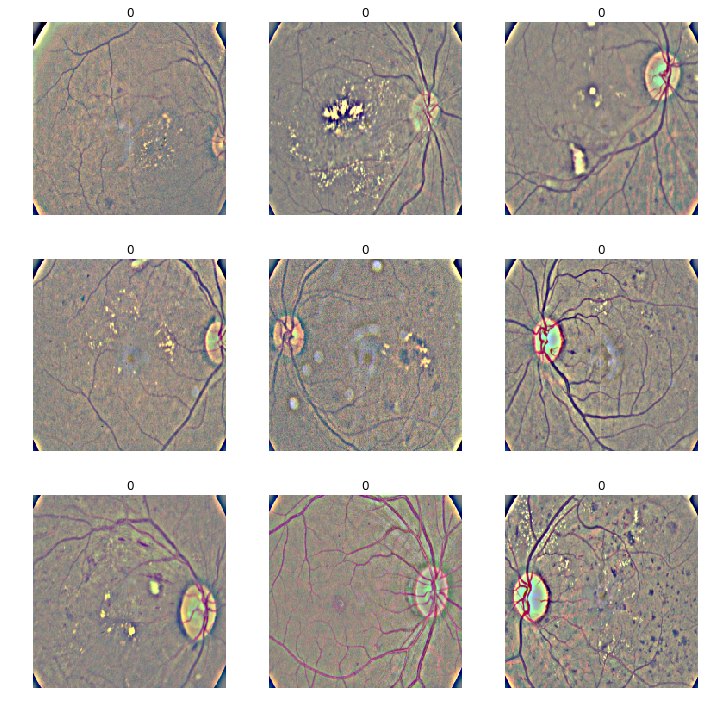

In [30]:
%%time
data.show_batch(rows=3, figsize=(10, 10), ds_type=DatasetType.Test)

## train

In [31]:
model = EfficientNet.from_pretrained(MODEL_NAME, num_classes=1) 
learn = Learner(data, model, path=p_o, 
#                 wd=WD,  
                metrics=[qwk])
if FP16: learn = learn.to_fp16()

Loaded pretrained weights for efficientnet-b5


In [32]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 33.3 s, sys: 4.15 s, total: 37.5 s
Wall time: 9min 46s


In [33]:
!nvidia-smi

Sun Jul 28 03:20:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   59C    P0    45W / 300W |  14811MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Min numerical gradient: 8.32E-04
Min loss divided by 10: 4.79E-03


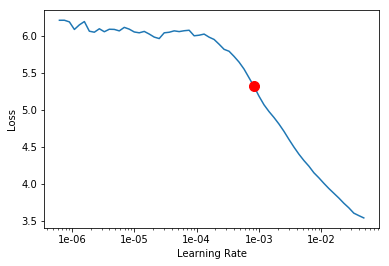

In [34]:
learn.recorder.plot(suggestion=True)

In [35]:
set_torch_seed()
learn.fit_one_cycle(20, max_lr=1e-3, 
                    callbacks=[SaveModelCallback(learn, 
                                                 every='epoch', 
                                                 name=f'{PRFX}_model')])



epoch,train_loss,valid_loss,qwk,time
0,1.746161,2.414954,0.472268,18:56
1,0.777566,0.905015,0.720922,18:16
2,0.612499,0.523665,0.836294,18:36
3,0.552438,0.691415,0.829895,18:56
4,0.534002,0.586854,0.806959,18:31
5,0.514638,0.580649,0.838253,19:16
6,0.509822,0.548614,0.847731,18:38
7,0.461710,0.643814,0.823024,18:17
8,0.444246,0.555946,0.842654,18:37
9,0.412632,0.457484,0.862729,18:55


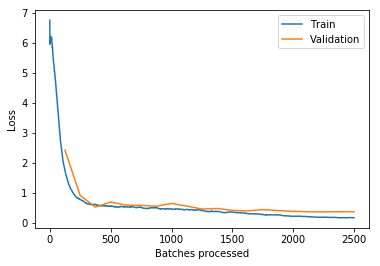

In [36]:
learn.recorder.plot_losses()

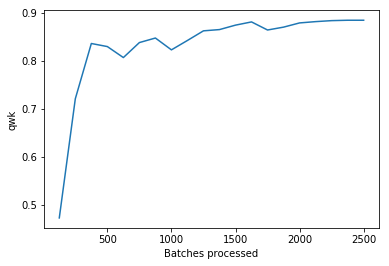

In [37]:
learn.recorder.plot_metrics()

# validate and thresholding

In [38]:
learn = learn.load(f'{PRFX}_model_8')

In [39]:
learn = learn.to_fp32()

In [40]:
%%time
set_torch_seed()
preds_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 3.32 s, sys: 1.7 s, total: 5.01 s
Wall time: 4min 11s


In [41]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [42]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [43]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 16.1 s, sys: 0 ns, total: 16.1 s
Wall time: 16.1 s


In [44]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 2.37 s, sys: 0 ns, total: 2.37 s
Wall time: 2.37 s


In [45]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0000660342883434,
  1.8606038880491154,
  2.734600720724374,
  3.496962463174497],
 'abhishek': array([0.464629, 1.588042, 2.744614, 3.674468])}

In [46]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [47]:
optnm2qwk

{'simple': 0.8500864497367089,
 'hocop1': 0.8625032720441275,
 'abhishek': 0.8638935298679533}

In [48]:
Counter(y_val).most_common()

[(4.0, 440), (3.0, 412), (1.0, 412), (2.0, 378), (0.0, 358)]

In [49]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [50]:
preds_val_grd.mean()

2.2835

In [51]:
Counter(preds_val_grd).most_common()

[(4.0, 537), (3.0, 455), (2.0, 361), (1.0, 332), (0.0, 315)]

In [52]:
list(zip(preds_val_grd, y_val))[:10]

[(3.0, 3.0),
 (3.0, 2.0),
 (1.0, 3.0),
 (3.0, 3.0),
 (4.0, 4.0),
 (4.0, 4.0),
 (3.0, 3.0),
 (2.0, 1.0),
 (2.0, 2.0),
 (4.0, 4.0)]

In [53]:
(preds_val_grd== y_val.squeeze()).mean()

0.6025

In [54]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

In [55]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_val_grd = bucket(preds_val, coef)
    display(pd.Series(preds_val_grd.squeeze().astype(int)).value_counts())

simple 0.8500864497367089 [0.5, 1.5, 2.5, 3.5]


4    537
3    455
2    361
1    332
0    315
dtype: int64

hocop1 0.8625032720441275 [1.0000660342883434, 1.8606038880491154, 2.734600720724374, 3.496962463174497]


4    538
0    405
1    369
3    349
2    339
dtype: int64

abhishek 0.8638935298679533 [0.464629 1.588042 2.744614 3.674468]


3    476
2    443
4    409
1    360
0    312
dtype: int64

# testing

In [56]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()

CPU times: user 3.4 s, sys: 1.34 s, total: 4.74 s
Wall time: 1min 2s


In [57]:
%%time
set_torch_seed()
preds_tst_tta, _ = learn.TTA(ds_type=DatasetType.Test)
preds_tst_tta = preds_tst_tta.numpy().squeeze()

CPU times: user 19.3 s, sys: 8.32 s, total: 27.7 s
Wall time: 6min 19s


In [58]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [59]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_tst_grd = bucket(preds_tst, coef)
    display(pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts())

simple 0.8500864497367089 [0.5, 1.5, 2.5, 3.5]


3    839
2    561
1    194
0    169
4    165
dtype: int64

hocop1 0.8625032720441275 [1.0000660342883434, 1.8606038880491154, 2.734600720724374, 3.496962463174497]


2    756
3    556
0    261
1    189
4    166
dtype: int64

abhishek 0.8638935298679533 [0.464629 1.588042 2.744614 3.674468]


2    828
3    608
1    225
0    160
4    107
dtype: int64

In [60]:
for optnm, coef in optnm2coefs.items():
    preds_tst_grd_tta = bucket(preds_tst_tta, coef)
    display(coef)
    display(pd.Series(preds_tst_grd_tta.squeeze().astype(int)).value_counts())


[0.5, 1.5, 2.5, 3.5]

3    899
2    459
4    217
0    196
1    157
dtype: int64

[1.0000660342883434, 1.8606038880491154, 2.734600720724374, 3.496962463174497]

2    668
3    613
0    282
4    217
1    148
dtype: int64

array([0.464629, 1.588042, 2.744614, 3.674468])

2    739
3    655
0    192
1    178
4    164
dtype: int64

In [61]:
for optnm, coef in optnm2coefs.items():
    preds_tst_grd = bucket(preds_tst, coef)
    display(coef)
    display(pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts())


[0.5, 1.5, 2.5, 3.5]

3    839
2    561
1    194
0    169
4    165
dtype: int64

[1.0000660342883434, 1.8606038880491154, 2.734600720724374, 3.496962463174497]

2    756
3    556
0    261
1    189
4    166
dtype: int64

array([0.464629, 1.588042, 2.744614, 3.674468])

2    828
3    608
1    225
0    160
4    107
dtype: int64

In [62]:
coef = optnm2coefs['hocop1']
preds_tst_grd = bucket(preds_tst, coef)
pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts()


2    756
3    556
0    261
1    189
4    166
dtype: int64

In [63]:
coef = optnm2coefs['simple']
preds_tst_grd = bucket(preds_tst, coef)
pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts()


3    839
2    561
1    194
0    169
4    165
dtype: int64

## submit

In [64]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,3
1,003f0afdcd15,4
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,3


In [65]:
subm.diagnosis.value_counts()

3    839
2    561
1    194
0    169
4    165
Name: diagnosis, dtype: int64

In [66]:
subm.to_csv(f"{p_o}/submission.csv", index=False)